# NCI60 use case

In [1]:
library("ISLR") 
library("evaluomeR")
library("dplyr")
library("caret")
library("MLmetrics")
library("ggplot2")
library("ggrepel")
library("reshape2")

options(scipen=10)
options(repr.plot.width = 5, repr.plot.height = 3.5) # Plot size

Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which

In [3]:
getRversion()
packageVersion("evaluomeR")

[1] '3.6.1'

[1] '1.7.11'

# Table of contents
* [Dataset](#dataset)
    * [Removing highly correlated metrics](#correlated)
    * [Top 200](#top)
* [evaluomeR - optimal $k$ analysis](#evaluomer)
    * [Stability plotting](#evaluomeR_stab_plot)
    * [Quality plotting](#evaluomeR_qual_plot)
* [PCA](#pca)
* [Sensitivity](#sensitivity)
* [CER](#cer)

# Dataset <a class="anchor" id="dataset"></a>

In [4]:
nci60 = as.data.frame(NCI60$data)
head(nci60)

,1,2,3,4,5,6,7,8,9,10,...,6821,6822,6823,6824,6825,6826,6827,6828,6829,6830
V1,0.300000,1.180000,0.550000,1.140000,-0.265000,-7.000000e-02,0.350000,-0.315000,-0.45000000,-0.65498050,...,-0.9900195,0.000000,0.030000,-0.175000,0.6299805,-0.030000,0.0000000,0.280000,-0.340000,-1.930000
V2,0.679961,1.289961,0.169961,0.379961,0.464961,5.799610e-01,0.699961,0.724961,-0.04003899,-0.28501950,...,-0.2700585,-0.300039,-0.250039,-0.535039,0.1099415,-0.860039,-1.2500490,-0.770039,-0.390039,-2.000039
V3,0.940000,-0.040000,-0.170000,-0.040000,-0.605000,0.000000e+00,0.090000,0.645000,0.43000000,0.47501950,...,0.3199805,0.120000,-0.740000,-0.595000,-0.2700195,-0.150000,0.0000000,-0.120000,-0.410000,0.000000
V4,0.280000,-0.310000,0.680000,-0.810000,0.625000,-1.387779e-17,0.170000,0.245000,0.02000000,0.09501949,...,-1.2400200,-0.110000,-0.160000,0.095000,-0.3500195,-0.300000,-1.1500100,1.090000,-0.260000,-1.100000
V5,0.485000,-0.465000,0.395000,0.905000,0.200000,-5.000000e-03,0.085000,0.110000,0.23500000,1.49001949,...,0.5549805,-0.775000,-0.515000,-0.320000,0.6349805,0.605000,0.0000000,0.745000,0.425000,0.145000
V6,0.310000,-0.030000,-0.100000,-0.460000,-0.205000,-5.400000e-01,-0.640000,-0.585000,-0.77000000,-0.24498050,...,-0.5900195,0.000000,-0.740000,-2.095000,-1.3900200,-0.400000,0.6999902,0.290000,0.550000,0.000000


There are 14 types of classes within the dataset: **CNS**, **RENAL**, **BREAST**, **NSCLC**, **UNKNOWN**, **OVARIAN**, **MELANOMA**, **PROSTATE**, **LEUKEMIA**, **K562B-repro**, **K562A-repro**, **COLON**, **MCF7A-repro** and **MCF7D-repro**:

In [5]:
as.vector(unlist(unique(NCI60$labs)))

[1] "CNS"         "RENAL"       "BREAST"      "NSCLC"       "UNKNOWN"    
 [6] "OVARIAN"     "MELANOMA"    "PROSTATE"    "LEUKEMIA"    "K562B-repro"
[11] "K562A-repro" "COLON"       "MCF7A-repro" "MCF7D-repro"

Here, we prepare the NCI60 dataset for the analysis:

- We add a column named `Description` containing the class (category) of each row
- Due to their small class size, we remove the two prostate cell lines and the unknown cell line, "PROSTATE" and "UNKNOWN" entires respectively.

In [6]:
nci60["labels"] = rownames(nci60)
nci60 = nci60[ , c("labels", names(nci60)[names(nci60) != "labels"])]
nci60["labels"] = NCI60$labs
colnames(nci60)[colnames(nci60) == 'labels'] <- 'Description'
nci60 = nci60[!grepl("UNKNOWN", nci60$Description),] # Remove UNKNOWN
nci60 = nci60[!grepl("PROSTATE", nci60$Description),] # Remove PROSTATE

## Removing highly correlated metrics <a class="anchor" id="correlated"></a>
We address the issue of multicorrelation by identifying and removing highly correlated metrics (absolute correlation, 1) from our dataset. First, we exclude the first column from the dataset `nci60`, where the column `Description` is. We then compute the correlation matrix R for data using the `cor` function. To pinpoint the metrics that exhibit perfect correlation (correlation coefficient of 1 or -1), we make use of the `findCorrelation` function from the `caret` package, setting a cutoff of 1. This function returns the names of the variables that are highly correlated, if any.

In [7]:
data = nci60[-1]
R = cor(data)
head(R)

1,2,3,4,5,6,7,8,9,10,...,6821,6822,6823,6824,6825,6826,6827,6828,6829,6830
1.00000000,0.3833056,0.22006157,0.08724557,-0.08602104,0.08949880,0.1158955,0.37934513,0.15316722,0.18856013,...,0.00107821,-0.13456921,-0.12645356,-0.201420268,-0.21480468,-0.04013097,-0.034189686,-0.02287118,-0.09639277,-0.06072415
0.38330561,1.0000000,0.36433000,0.21617498,0.16558775,0.21444133,0.3699355,0.07807990,0.24695819,0.07245724,...,-0.02944743,-0.10859360,-0.04041393,0.003900317,0.02573318,-0.04360088,0.000302537,-0.06442559,-0.03610617,-0.05866152
0.22006157,0.3643300,1.00000000,0.23689049,0.12153801,0.03343932,0.1134791,0.01143216,-0.05276462,0.23168582,...,0.05290187,0.01976031,0.07319763,0.045394869,0.07732554,-0.12526880,-0.036734630,0.12118781,0.09385166,0.08099348
0.08724557,0.2161750,0.23689049,1.00000000,0.13438601,0.12715055,0.0590030,-0.06803698,-0.01874263,-0.12446127,...,-0.22308278,-0.28758473,-0.23071174,-0.259432992,-0.09173215,-0.17711090,0.001642882,-0.03740982,-0.03359966,-0.01586329
-0.08602104,0.1655877,0.12153801,0.13438601,1.00000000,0.26872823,0.2303654,-0.05813832,-0.04957305,-0.14754158,...,-0.17174975,-0.20977705,-0.14449000,-0.072001176,-0.13047178,0.10183611,0.073267124,-0.02843955,0.04111594,-0.06184830
0.08949880,0.2144413,0.03343932,0.12715055,0.26872823,1.00000000,0.4908452,0.19822509,0.22885592,0.05951340,...,-0.34521929,-0.26279137,-0.29911896,-0.143450848,-0.21673796,-0.21725913,-0.298911041,-0.22827261,-0.23197988,-0.20448364


In [8]:
cor_metrics = findCorrelation(R, cutoff = 1, verbose = FALSE, names=TRUE)
length(cor_metrics)

[1] 0

Finally, we use `length(cor_metrics)` to determine the number of these highly correlated metrics. As this number is 0, we assess there are no highly correlated metrics.

## Top 200 <a class="anchor" id="top"></a>

We now filter the metrics for including only the top 200 with the greatest variance, as these metrics have the most significant impact on clustering.

In [9]:
variance = sort(sapply(nci60[-1], var), decreasing = TRUE)  # Sorted gene variance
nci60_var = as.data.frame(variance)
nci60_var["Description"] = rownames(nci60_var)

In [10]:
top_number = 200
top_rows = nci60_var[c(1:top_number), ]
head(top_rows)

,variance,Description
4701,11.942075,4701
4700,11.429800,4700
256,7.978482,256
16,7.715338,16
4699,7.711871,4699
6393,7.659845,6393


In [11]:
row_list = as.list(top_rows["Description"])
top_row_list = unlist(setdiff(row_list, names(nci60)))
top_nci60 = nci60[, top_row_list]
top_nci60["Description"] = nci60[rownames(top_nci60) %in% rownames(nci60), "Description"]
top_nci60 = top_nci60[ , c("Description", names(top_nci60)[names(top_nci60) != "Description"])] 

The dataframe `top_nci60` contains 200 genes (metrics) which provides the most variance.

In [12]:
head(top_nci60)

,Description,4701,4700,256,16,4699,6393,6149,286,6415,...,5721,6622,5336,1067,6288,5872,5489,78,127,3383
V1,CNS,5.770000,5.820000,-1.910000,-2.37,4.760000,5.4799900,0.000000,0.610000,5.230000,...,2.790000,1.210000,-0.890000,-1.055010,-2.1850100,0.045000,1.990000,2.360000,-1.305000,-0.5400195
V2,CNS,5.039961,5.069961,-1.980039,0.00,4.779961,5.7299510,-0.480039,-3.980039,5.329961,...,1.629961,1.599961,-1.060039,-1.055049,-3.4050490,0.874961,2.609961,0.869961,-0.375039,0.4799415
V3,CNS,-1.440000,-1.030000,-0.580000,0.00,0.000000,4.6299900,2.060000,-1.580000,0.000000,...,1.920000,-0.260000,0.000000,1.294990,-0.6850098,1.445000,0.200000,1.990000,0.705000,0.3199805
V4,RENAL,-2.420000,-2.420000,-1.880000,-1.02,-2.590000,1.2999900,5.190000,-4.880000,7.020000,...,3.200000,1.110000,1.060000,1.414990,-4.4750100,2.365000,1.080000,3.600000,-0.685000,0.1399805
V5,BREAST,-2.955000,-2.955000,-1.235000,0.00,-2.535000,-1.0550098,7.425000,-3.235000,4.395000,...,2.865000,1.245000,0.000000,-1.480010,-3.8300098,3.320000,-1.155000,-1.385000,-1.220000,0.4449805
V6,CNS,0.000000,-3.180000,-3.050000,-0.05,-1.170000,0.5899902,4.230000,-5.050000,-0.220000,...,2.860000,1.360000,0.000000,-1.425010,-2.2550100,1.615000,-0.970000,1.370000,-2.445000,-1.5400200


# evaluomeR - optimal $k$ analysis <a class="anchor" id="evaluomer"></a>
In this Section, evaluomeR executes an optimal $k$ analysis. First, stabilities and qualities are calculated, considering all the metrics in the dataset. The $k$ range is $k \in [3,10]$ and the clustering method is `kmeans`.

In [13]:
seed = 13606
k.range=c(3,10)
cbis = evaluomeRSupportedCBI()[! evaluomeRSupportedCBI() %in% c("rskc", "pamk", "pamk_pam")]

In [15]:
stab_all = list()
stab_melt_all = NULL 
for (cbi in cbis) {
    stab_range = stabilityRange(data=top_nci60, k.range=k.range, 
                            bs=100, seed=seed,
                            all_metrics=TRUE,
                            cbi=cbi)
    stab = standardizeStabilityData(stab_range)
    colnames(stab) <- gsub("k_", "", colnames(stab))
    stab_all[[cbi]] = stab_range
    
    rownames(stab) = c(paste0("stab_", cbi))
    stab$Metric = rownames(stab)
    stab$Method = cbi
    stab_melt = melt(stab, id.vars = c("Metric", "Method"))
     if (is.null(stab_melt_all)) {
        stab_melt_all = stab_melt
    } else {
        stab_melt_all = rbind(stab_melt_all, stab_melt)
    }
}


Data loaded.
Number of rows: 61
Number of columns: 201


Processing all metrics, 'merge', in dataframe (200)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10

Data loaded.
Number of rows: 61
Number of columns: 201


Processing all metrics, 'merge', in dataframe (200)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10

Data loaded.
Number of rows: 61
Number of columns: 201


Processing all metrics, 'merge', in dataframe (200)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10

Data loaded.
Number of rows: 61
Number of columns: 201


Processing all metrics, 'merge', in dataframe (200)
	Calculation of k = 3
	Calcul

## Stability plotting <a class="anchor" id="evaluomeR_stab_plot"></a>

Stability plot

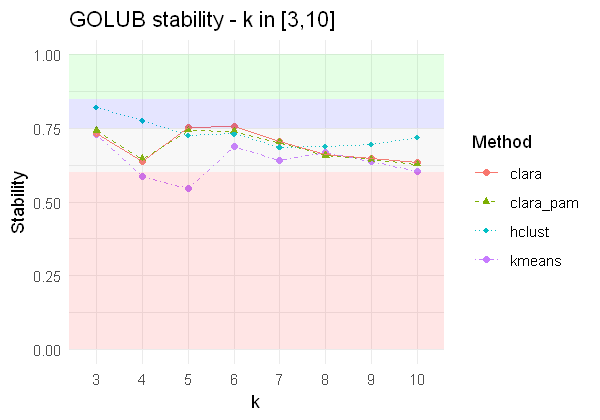

In [16]:
all_linetypes <- c("solid", "dashed", "dotted", "dotdash", "longdash", "twodash")
linetype_values <- rep(all_linetypes, length.out = length(unique(stab_melt_all$Method)))
shape_values <- rep(16:25, length.out = length(unique(stab_melt_all$Method)))

p <- ggplot(stab_melt_all, aes(x = variable, y = value, color = Method, group = Method, linetype = Method, shape = Method)) +
  geom_point() +
  geom_line() +
  scale_linetype_manual(values = linetype_values) +
  scale_shape_manual(values = shape_values) +
  labs(
    title = paste0('GOLUB stability - k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Stability'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal()

p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.1, fill = "blue") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.1, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.1, fill = "red")



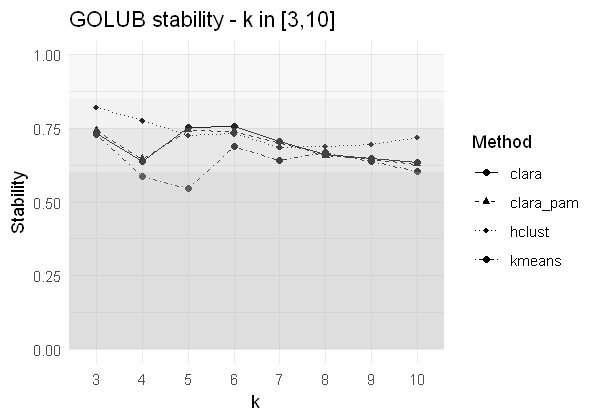

In [17]:
all_linetypes <- c("solid", "dashed", "dotted", "dotdash", "longdash", "twodash")
linetype_values <- rep(all_linetypes, length.out = length(unique(stab_melt_all$Method)))
shape_values <- rep(16:25, length.out = length(unique(stab_melt_all$Method)))

p <- ggplot(stab_melt_all, aes(x = variable, y = value, linetype = Method, shape = Method, group = Method)) +
  geom_point() +
  geom_line() +
  scale_linetype_manual(values = linetype_values) +
  scale_shape_manual(values = shape_values) +
  labs(
    title = paste0('GOLUB stability - k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Stability'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal() +
  theme(legend.position = "right") +
  theme(legend.key = element_blank())

p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.1, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.2, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.35, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.5, fill = "gray")

In [18]:
qual_all = list()
qual_melt_all = NULL 
for (cbi in cbis) {
    qual_range = qualityRange(data=top_nci60, k.range=k.range, 
                            all_metrics=TRUE, seed=seed,
                            cbi=cbi)
    qual = standardizeQualityData(qual_range)
    colnames(qual) <- gsub("k_", "", colnames(qual))
    qual_all[[cbi]] = qual_range
    
    rownames(qual) = c(paste0("qual_", cbi))
    qual$Metric = rownames(qual)
    qual$Method = cbi
    qual_melt = melt(qual, id.vars = c("Metric", "Method"))
     if (is.null(qual_melt_all)) {
        qual_melt_all = qual_melt
    } else {
        qual_melt_all = rbind(qual_melt_all, qual_melt)
    }
}


Data loaded.
Number of rows: 61
Number of columns: 201


Processing all metrics, 'merge', in dataframe (200)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10

Data loaded.
Number of rows: 61
Number of columns: 201


Processing all metrics, 'merge', in dataframe (200)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10

Data loaded.
Number of rows: 61
Number of columns: 201


Processing all metrics, 'merge', in dataframe (200)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10

Data loaded.
Number of rows: 61
Number of columns: 201


Processing all metrics, 'merge', in dataframe (200)
	Calculation of k = 3
	Calcul

## Quality plotting <a class="anchor" id="evaluomeR_qual_plot"></a>

Quality plot

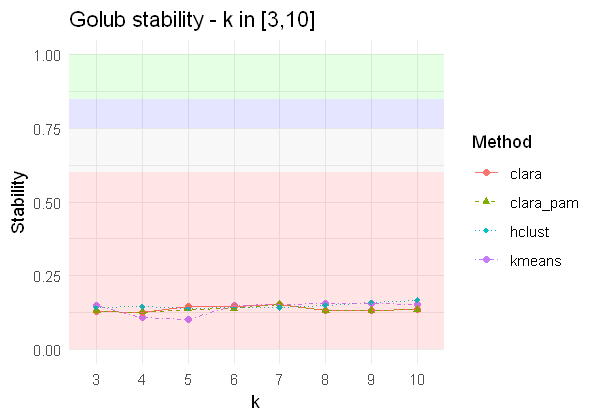

In [19]:
all_linetypes <- c("solid", "dashed", "dotted", "dotdash", "longdash", "twodash")
linetype_values <- rep(all_linetypes, length.out = length(unique(stab_melt_all$Method)))
shape_values <- rep(16:25, length.out = length(unique(stab_melt_all$Method)))

p <- ggplot(qual_melt_all, aes(x = variable, y = value, color = Method, group = Method, linetype = Method, shape = Method)) +
  geom_point() +
  geom_line() +
  scale_linetype_manual(values = linetype_values) +
  scale_shape_manual(values = shape_values) +
  labs(
    title = paste0('Golub stability - k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Stability'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal()

p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.1, fill = "blue") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.1, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.1, fill = "red")

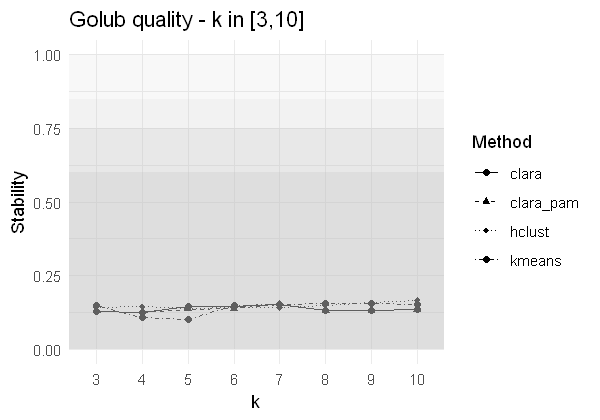

In [20]:
all_linetypes <- c("solid", "dashed", "dotted", "dotdash", "longdash", "twodash")
linetype_values <- rep(all_linetypes, length.out = length(unique(stab_melt_all$Method)))
shape_values <- rep(16:25, length.out = length(unique(stab_melt_all$Method)))

p <- ggplot(qual_melt_all, aes(x = variable, y = value, linetype = Method, shape = Method, group = Method)) +
  geom_point() +
  geom_line() +
  scale_linetype_manual(values = linetype_values) +
  scale_shape_manual(values = shape_values) +
  labs(
    title = paste0('Golub quality - k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Stability'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal() +
  theme(legend.position = "right") +
  theme(legend.key = element_blank())

p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.1, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.2, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.35, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.5, fill = "gray")

Determining the optimal $k$ given the stabilities and qualities in `stab_range` and `qual_range` objects:

In [21]:
for (cbi in cbis) {
    k_opt = getOptimalKValue(stab_all[[cbi]], qual_all[[cbi]], k.range= k.range)
    optimal_k = k_opt$Global_optimal_k
    optimal_k_str = paste0("k_", optimal_k)
    print(paste0("Optimal k with '", cbi, "' is: ", optimal_k))
}

Processing metric: all_metrics

	Both Ks do not have a stable classification: '3', '8'

	Using '8' since it provides higher silhouette width



[1] "Optimal k with 'kmeans' is: 8"


Processing metric: all_metrics

	Stability k '6' is stable but its silhouette value is not reasonable

	Using stability '6' since quality k is not reasonable



[1] "Optimal k with 'clara' is: 6"


Processing metric: all_metrics

	Both Ks do not have a stable classification: '5', '7'

	Using '7' since it provides higher silhouette width



[1] "Optimal k with 'clara_pam' is: 7"


Processing metric: all_metrics

	Stability k '3' is stable but its silhouette value is not reasonable

	Using stability '3' since quality k is not reasonable



[1] "Optimal k with 'hclust' is: 3"
